### Setup installation for Tensorflow2 object detection

In [2]:
# 1. Download/clone repo > https://github.com/tensorflow/models
# 2. pip install pillow lxml Cython contextlib2 matplotlib pandas opencv-python tensorflow pycocotools
# 3. conda install -c anaconda protocol
# 4. cd models/research && protoc object_detection/protos/*.proto --python_out=.
# 5. cd models/research/object_detection/packages/tf2 && pip install .

### imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import pathlib
import shutil
import tensorflow as tf
import zipfile
import cv2

from tqdm import tqdm
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [2]:
sys.path.append(os.path.join(os.path.abspath(os.getcwd()), 'models','research'))

In [3]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [4]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

### Model prepearation

In [5]:
def load_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
        fname=model_name, 
        origin=base_url + model_file,
        untar=True)

    model_dir = pathlib.Path(model_dir)/"saved_model"

    model = tf.saved_model.load(str(model_dir))
    print(str(model_dir))
    
    return model

In [6]:
model_name = 'ssd_mobilenet_v2_320x320_coco17_tpu-8'
detection_model = load_model(model_name)

C:\Users\Pc-Klinik\.keras\datasets\ssd_mobilenet_v2_320x320_coco17_tpu-8\saved_model


### Input output signature of model

In [27]:
print(detection_model.signatures['serving_default'].inputs)
print('\n\n')
print(detection_model.signatures['serving_default'].output_dtypes)
print('\n\n')
print(detection_model.signatures['serving_default'].output_shapes)

[<tf.Tensor 'input_tensor:0' shape=(1, None, None, 3) dtype=uint8>, <tf.Tensor 'unknown:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_0:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_1:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_2:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_3:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_4:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_5:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_6:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_7:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_8:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_9:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_10:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_11:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_12:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_13:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_14:0' shape=<unknown> dtype=resource>, <

### Label mapping

In [7]:
PATH_TO_LABELS = os.path.join(os.getcwd(),'models','research','object_detection','data','mscoco_label_map.pbtxt')
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

In [8]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
    if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                output_dict['detection_masks'], output_dict['detection_boxes'],
                image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
    return output_dict

In [9]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
    image_np = np.array(Image.open(image_path))
  # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

    display(Image.fromarray(image_np))

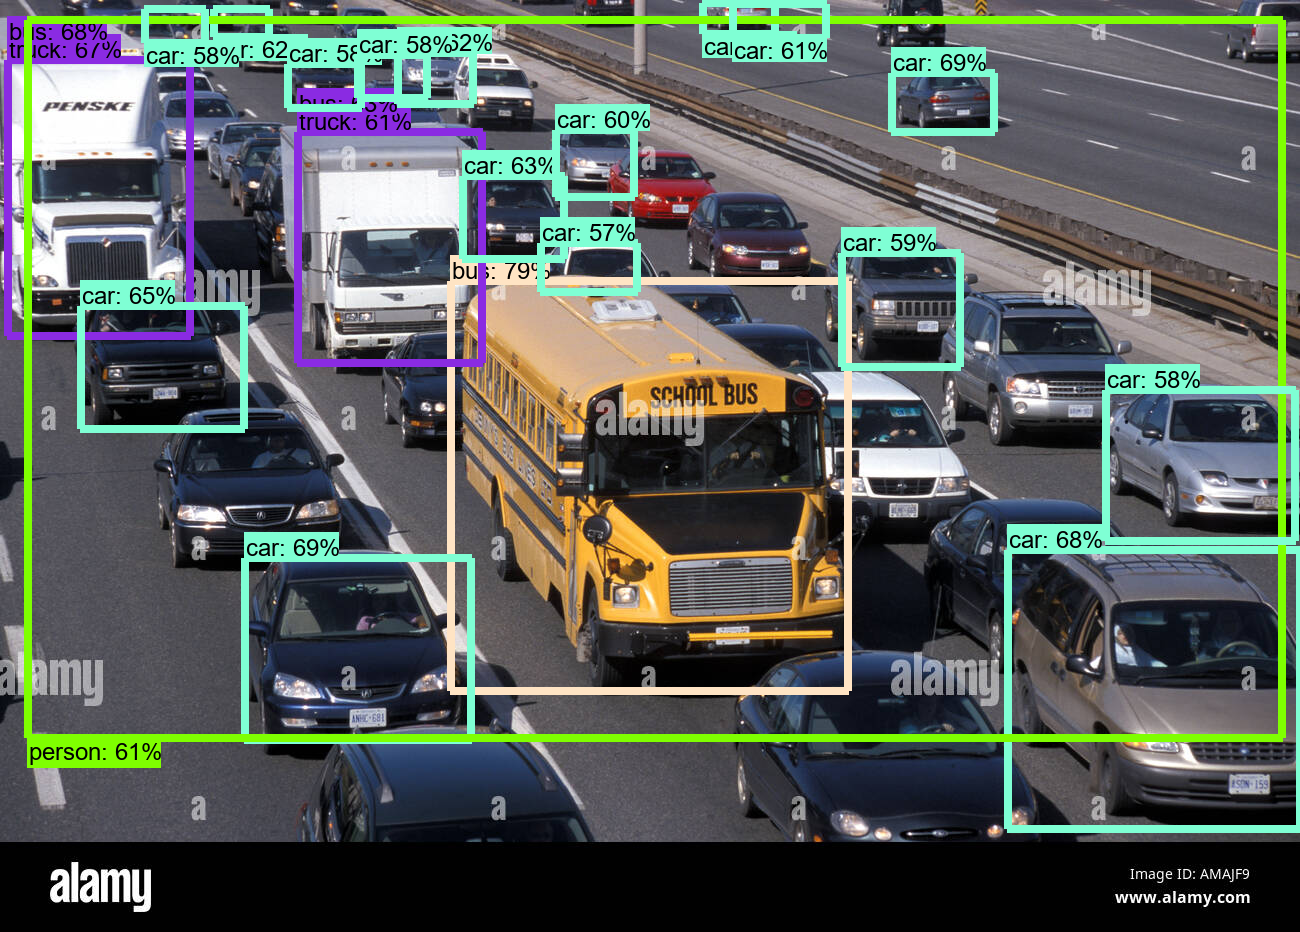

In [10]:
image_path = os.path.join(os.getcwd(),'sample_test1.jpg')
show_inference(detection_model, image_path)

### WebCam inference

In [11]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Make detections 
    output_dict = run_inference_for_single_image(detection_model, frame)
    
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      frame,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=6)
    
    cv2.imshow('SSD', frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 

### Sample Video object Detection

In [12]:
vid_path = os.path.join(os.getcwd(), "Highway_Traffic.mp4")
sample_output = os.path.join(os.getcwd(), 'sample_output.mp4')

In [13]:
vid = cv2.VideoCapture(vid_path)
total_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
vid_fps = int(vid.get(cv2.CAP_PROP_FPS))
vid_width, vid_height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))

# codec = cv2.VideoWriter_fourcc(*'XVID')
# out = cv2.VideoWriter(sample_output, codec, vid_fps, (vid_width, vid_height))

for _ in tqdm(range(total_frames)): #tqdm is progress bar ()
                             
    ret, frame = vid.read()
    if not ret:
        break
       
    # Make detections 
    output_dict = run_inference_for_single_image(detection_model, frame)
    
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      frame,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=6)
    
    cv2.imshow('SSD', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
#     out.write(final_frame)
   
vid.release()
# out.release()
cv2.destroyAllWindows()

 11%|██████████████▌                                                                                                                    | 503/4509 [02:04<16:31,  4.04it/s]
